In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## データの読み込み

In [17]:
raw_dir = "/content/drive/MyDrive/competitions/probspace_pricing/data/raw/"
features_dir = "/content/drive/MyDrive/competitions/probspace_pricing/data/features/"
submission_dir = "/content/drive/MyDrive/competitions/probspace_pricing/data/submission/"

In [18]:
# rawデータ
train_df = pd.read_csv(raw_dir + "train.csv")
test_df = pd.read_csv(raw_dir + "test.csv")
all_df = pd.concat([train_df, test_df]).reset_index()

In [19]:
# LightGBMの予測値
lgb_pred = pd.read_csv(features_dir + "lightgbm_pred.csv")

In [20]:
# BERTの予測値
bert_reg_description = pd.read_csv(features_dir + "Description_pred.csv")
bert_reg_ownerdetail = pd.read_csv(features_dir + "OwnerDetail_pred.csv")
bert_reg_propertytype = pd.read_csv(features_dir + "PropertyType_pred.csv")
bert_reg_amenities = pd.read_csv(features_dir + "Amenities_pred.csv")
bert_reg_review = pd.read_csv(features_dir + "Review_pred.csv")
bert_reg_conbine_pt_am = pd.read_csv(features_dir + "conbine_PT_Am_pred.csv")
bert_reg_conbine_od_ds = pd.read_csv(features_dir + "conbine_OD_Ds_pred.csv")

# 対数変換を戻してdfに格納

In [21]:
# dfを追加してく
df_list = [lgb_pred, 
           bert_reg_description,
           bert_reg_ownerdetail,
           bert_reg_propertytype,
           bert_reg_amenities,
           bert_reg_review,
           bert_reg_conbine_pt_am,
           bert_reg_conbine_od_ds,
           ]

In [22]:
# 対数変換を戻してdfに格納する
pred_df = all_df[["ID", "Price"]]
for df_i in df_list:
    # inverse 対数変換
    df_i.iloc[:,1] = df_i.iloc[:,1].apply(lambda x: np.expm1(x))
    # dfに格納
    pred_df = pd.merge(pred_df, df_i, on="ID", how="inner")

# 平均値を追加
pred_df["average_pred"] = pred_df.iloc[:,2:].mean(axis=1)

In [23]:
pred_df.head(10)

,ID,Price,lightgbm_pred,Description_pred,OwnerDetail_pred,PropertyType_pred,Amenities_pred,Review_pred,conbine_PT_Am_pred,conbine_OD_Ds_pred,average_pred
0,0,898.0,1035.523033,3854.002752,NaN,3331.953077,1171.834796,NaN,1549.425983,1825.251346,2127.998498
1,1,609213.0,13113.527502,6030.204373,NaN,6954.166196,4049.096553,NaN,4891.486794,4137.968992,6529.408402
2,2,3631.0,4283.725875,22083.074127,NaN,4060.862942,5111.828231,NaN,7562.429471,7648.335039,8458.375947
3,3,5697.0,5253.679222,7977.574178,6035.834113,8392.425502,5416.466231,NaN,6910.389625,6643.222772,6661.370234
4,4,2548.0,3452.539963,4999.499068,3220.485927,6954.166196,3881.035855,NaN,3810.088032,2866.833943,4169.235569
5,5,1772.0,1900.207580,2881.216802,2183.461447,3331.953077,4351.910584,NaN,1905.013182,1952.170053,2643.704675
6,6,2057.0,2065.758381,7194.024324,2603.197903,6954.166196,2329.786399,2184.576681,2741.669513,3398.185082,3683.920560
7,7,7521.0,6892.665580,10954.041059,NaN,6954.166196,9804.473214,5738.463396,9929.965670,6389.501332,8094.753778
8,8,1685.0,1783.362505,5217.211512,NaN,6954.166196,2649.275829,NaN,2620.094873,3323.451576,3757.927082
9,9,12144.0,13620.672871,48717.153431,18297.273681,6954.166196,21192.207322,11644.638369,19168.466391,14340.131268,19241.838691


In [24]:
pred_df.isnull().sum()

ID                        0
Price                 30286
lightgbm_pred             0
Description_pred       1707
OwnerDetail_pred      29122
PropertyType_pred         0
Amenities_pred            0
Review_pred           44716
conbine_PT_Am_pred        0
conbine_OD_Ds_pred     1004
average_pred              0
dtype: int64

# MAPEの比較

In [25]:
from sklearn.metrics import mean_absolute_percentage_error

In [26]:
print("MAPE")
for col_pred in pred_df.columns[2:]:
    train = pred_df.iloc[:len(train_df)]
    train = train[train[col_pred].notnull()]
    score = mean_absolute_percentage_error(train["Price"], train[col_pred])
    print(col_pred, ":", score)

MAPE
lightgbm_pred : 0.18372489160941435
Description_pred : 1.3028761525887844
OwnerDetail_pred : 0.4723751403134962
PropertyType_pred : 0.9102932979578419
Amenities_pred : 0.4697817661629583
Review_pred : 0.32675024927402174
conbine_PT_Am_pred : 0.4398353288750322
conbine_OD_Ds_pred : 0.3824218347219819
average_pred : 0.4789155385132327


# アンサンブルモデルによる予測

In [27]:
!pip install lightgbm==3.3.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 5.1 MB/s 
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 2.2.3
    Uninstalling lightgbm-2.2.3:
      Successfully uninstalled lightgbm-2.2.3


In [28]:
import lightgbm as lgb
from sklearn.model_selection import ShuffleSplit

In [43]:
df = pred_df[["ID", "Price", "lightgbm_pred", "Description_pred", "OwnerDetail_pred", "Review_pred", "conbine_PT_Am_pred", "conbine_OD_Ds_pred"]]
df = pred_df[["ID", "Price", "lightgbm_pred", "Review_pred", "conbine_PT_Am_pred", "conbine_OD_Ds_pred"]]

In [44]:
# データ準備
train = df[:len(train_df)].drop(columns=["ID"])
test = df[len(train_df):].drop(columns=["ID","Price"])
train_x = train.drop(columns=["Price"])
train_y = train["Price"]

In [45]:
# 評価指標がMAEのため、あらかじめ目的変数に対数変換を施しておく
train_y = np.log1p(train_y)

In [46]:
%%time
params = {
    'boosting_type': 'gbdt', # fairとするとこれがないとうまくいかない
    'objective': 'fair', # fair loss
    'metric': 'fair', # fair loss
    'learning_rate': 0.1,
    "verbosity": 1,
    'early_stopping_rounds':100,
}

cv = lgb.cv(
    params = params,
    train_set = lgb.Dataset(train_x, label=train_y),
    num_boost_round = 1000,
    folds = ShuffleSplit(n_splits=5, test_size=0.2, random_state=123),
    metrics="mape",
    seed = 0,
    return_cvbooster = True,
)

model = cv["cvbooster"]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001566 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 31580, number of used features: 4
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001562 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 31580, number of used features: 4
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001538 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 31580, number of used features: 4
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001487 seconds.
You can set `force_c

In [47]:
cv["mape-mean"].pop()

0.021018015985847814

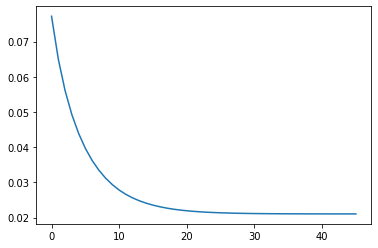

In [48]:
plt.plot(cv["mape-mean"])

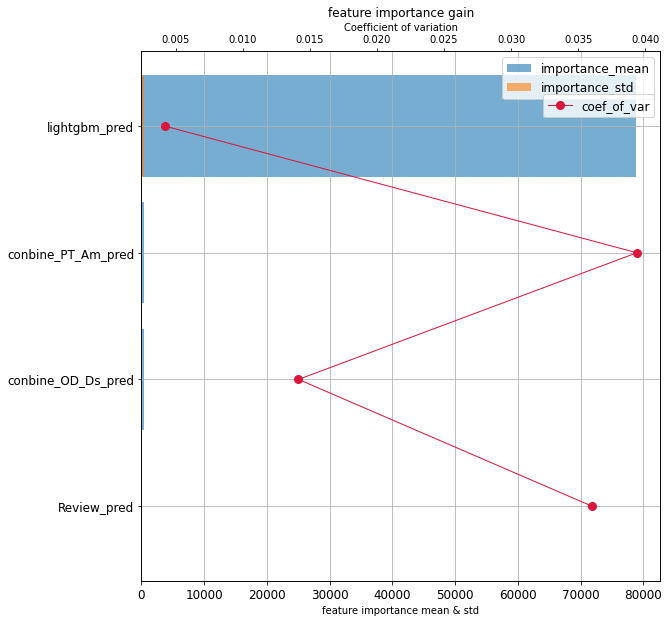

In [49]:
def calc_feature_importance(cv_model, features):
    """feature importanceの計算,図の保存
    """
    val_gain = pd.DataFrame(data=model.feature_importance(importance_type='gain'),
                            columns=model.boosters[0].feature_name()).T

    # 各foldの平均を算出
    val_mean = val_gain.mean(axis=1)
    val_mean = val_mean.values
    importance_df_mean = pd.DataFrame(val_mean, index=features, columns=['importance']).sort_values('importance')

    # 各foldの標準偏差を算出
    val_std = val_gain.std(axis=1)
    val_std = val_std.values
    importance_df_std = pd.DataFrame(val_std, index=features, columns=['importance']).sort_values('importance')

    # マージ
    df = pd.merge(importance_df_mean, importance_df_std, left_index=True, right_index=True ,suffixes=['_mean', '_std'])

    # 変動係数を算出
    df['coef_of_var'] = df['importance_std'] / df['importance_mean']
    df['coef_of_var'] = df['coef_of_var'].fillna(0)
    df = df.sort_values('importance_mean', ascending=True)

    # 出力
    fig, ax1 = plt.subplots(figsize = (8, 8))
    plt.tick_params(labelsize=12) # 図のラベルのfontサイズ
    plt.tight_layout()
    # 棒グラフを出力
    ax1.set_title('feature importance gain')
    ax1.set_xlabel('feature importance mean & std')
    ax1.barh(df.index, df['importance_mean'], label='importance_mean',  align="center", alpha=0.6)
    ax1.barh(df.index, df['importance_std'], label='importance_std',  align="center", alpha=0.6)
    # 折れ線グラフを出力
    ax2 = ax1.twiny()
    ax2.plot(df['coef_of_var'], df.index, linewidth=1, color="crimson", marker="o", markersize=8, label='coef_of_var')
    ax2.set_xlabel('Coefficient of variation')
    # 凡例を表示（グラフ左上、ax2をax1のやや下に持っていく）
    ax1.legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=0.5, fontsize=12)
    ax2.legend(bbox_to_anchor=(1, 0.93), loc='upper right', borderaxespad=0.5, fontsize=12)
    # グリッド表示(ax1のみ)
    ax1.grid(True)
    ax2.grid(False)


calc_feature_importance(cv_model=model, features=model.boosters[0].feature_name())

# 提出

In [ ]:
# アンサンブルの予測値
ans_pred = np.expm1(np.array(model.predict(test)).mean(axis=0))

In [ ]:
# BERTの予測値
bert_pred = bert_reg_description[len(train_df):]["Description_pred"].values

In [ ]:
# BERTの予測値
import datetime
sub_df = pd.read_csv(raw_dir + "sample_submission.csv")
sub_df["Price"] = ans_pred
sub_df.to_csv(submission_dir + "submission_{}_{}.csv".format("ansamble_", str(datetime.date.today())),
              index = False, header = True)